In [2]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)


# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)

    return M

In [3]:
# Load Load fsLR 5k
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load fsLR 5k inflated
f5k_inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
f5k_inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

In [6]:
dir_s2 = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC019/ses-02/mpc-swm/'
dir_s1 = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC019/ses-01/mpc-swm/'

fsLR5k_s2 = 'sub-PNC019_ses-02_surf-fsLR-5k_desc-intensity_profiles.shape.gii'
fsLR5k_s1 = 'sub-PNC019_ses-01_surf-fsLR-5k_desc-intensity_profiles.shape.gii'

swm_odi = dir_s2 + 'acq-ODI/' + fsLR5k_s2
#swm_ficvf = dir_s2 + 'acq-ficvf/' + fsLR5k_s2
#swm_fiso = dir_s2 + 'acq-fiso/' + fsLR5k_s2

#swm_tfod_afd = dir_s1 + 'acq-tournier_afd/' + fsLR5k_s1
#swm_tfod_disp = dir_s1 + 'acq-tournier_dispersion/' + fsLR5k_s1
#swm_tfod_peak = dir_s1 + 'acq-tournier_peak/' + fsLR5k_s1
#swm_dfod_afd = dir_s1 + 'acq-dhollander_afd/' + fsLR5k_s1
#swm_dfod_disp = dir_s1 + 'acq-dhollander_dispersion/' + fsLR5k_s1
#swm_dfod_peak = dir_s1 + 'acq-dhollander_peak/' + fsLR5k_s1


arr_odi = nb.load(swm_odi).darrays[0].data
#arr_ficvf = nb.load(swm_ficvf).darrays[0].data
#arr_fiso = nb.load(swm_fiso).darrays[0].data

#arr_tfod_afd = nb.load(swm_tfod_afd).darrays[0].data
#arr_tfod_disp = nb.load(swm_tfod_disp).darrays[0].data
#arr_tfod_peak = nb.load(swm_tfod_peak).darrays[0].data
#arr_dfod_afd = nb.load(swm_dfod_afd).darrays[0].data
#arr_dfod_disp = nb.load(swm_dfod_disp).darrays[0].data
#arr_dfod_peak = nb.load(swm_dfod_peak).darrays[0].data

In [7]:
arr_odi.shape

(16, 9684)

In [5]:
odi_1mm = arr_odi[5, :]
odi_2mm = arr_odi[10, :]
odi_3mm = arr_odi[15, :]
ficvf_1mm = arr_ficvf[5, :]
ficvf_2mm = arr_ficvf[10, :]
ficvf_3mm = arr_ficvf[15, :]
fiso_1mm = arr_fiso[5, :]
fiso_2mm = arr_fiso[10, :]
fiso_3mm = arr_fiso[15, :]

tfod_afd_1mm = arr_tfod_afd[5, :]
tfod_disp_1mm = arr_tfod_disp[5, :]
tfod_peak_1mm = arr_tfod_peak[5, :]
dfod_afd_1mm = arr_dfod_afd[5, :]
dfod_disp_1mm = arr_dfod_disp[5, :]
dfod_peak_1mm = arr_dfod_peak[5, :]

In [6]:
odi_1mm[mask_10k == False] = np.nan
ficvf_1mm[mask_10k == False] = np.nan
fiso_1mm[mask_10k == False] = np.nan

tfod_afd_1mm[mask_10k == False] = np.nan
tfod_disp_1mm[mask_10k == False] = np.nan
tfod_peak_1mm[mask_10k == False] = np.nan
dfod_afd_1mm[mask_10k == False] = np.nan
dfod_disp_1mm[mask_10k == False] = np.nan
dfod_peak_1mm[mask_10k == False] = np.nan

# NODDI - Orientation dispertion Index (ODI)

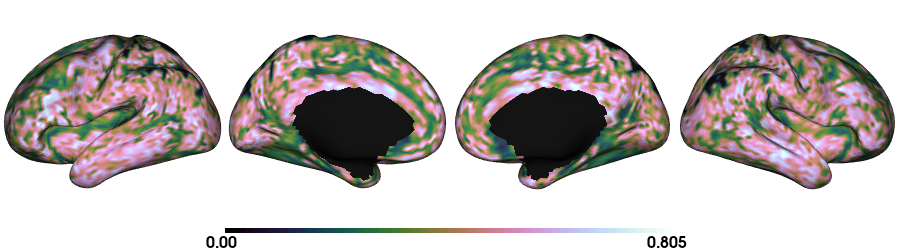

In [49]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=odi_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# NODDI - Intra cellular volume fraction (ICVF)

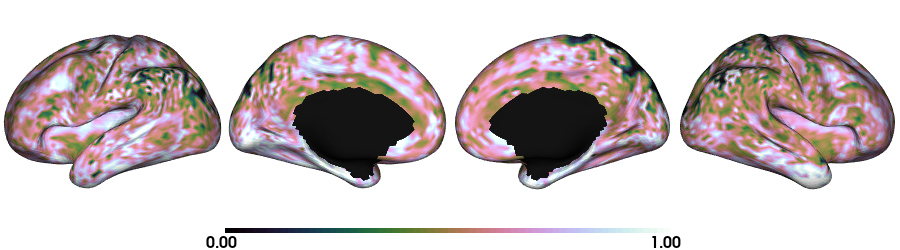

In [50]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=ficvf_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# NODDI - fISO

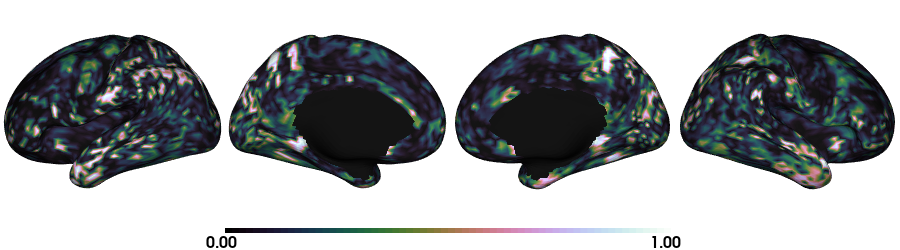

In [117]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=fiso_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False, color_range=(0,1))

/tmp/ipykernel_3263371/3348255606.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


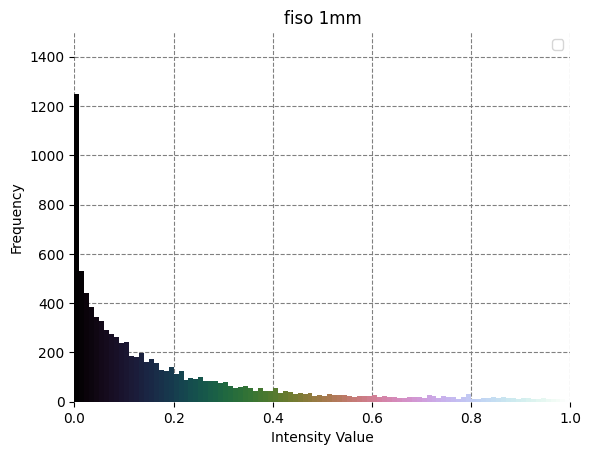

In [113]:
plot_histogram(fiso_1mm, bins=100, title='fiso 1mm', cmap='cubehelix', Range=(0,1),
                   xlim=[0,1], ylim=1500)

# FOD Tournier  - Apparent Fiber Distribution (ADF)

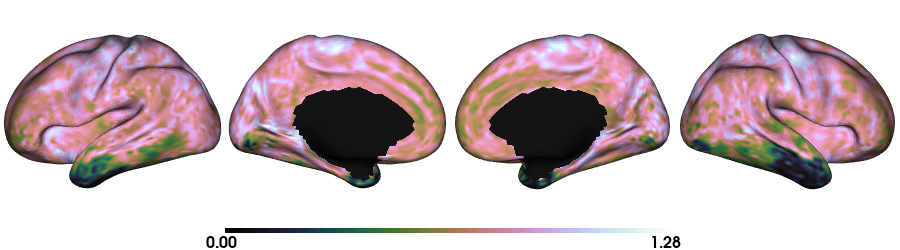

In [199]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=tfod_afd_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

/tmp/ipykernel_3263371/237024525.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


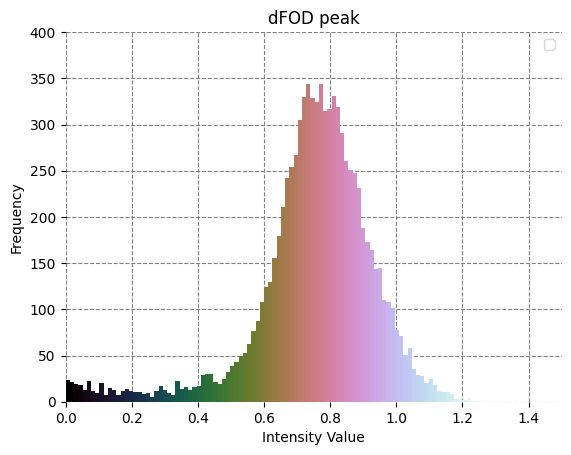

In [200]:
plot_histogram(tfod_afd_1mm, bins=100, title='dFOD peak', cmap='cubehelix', Range=(0, 1.3),
                   xlim=[0,1.5], ylim=400)

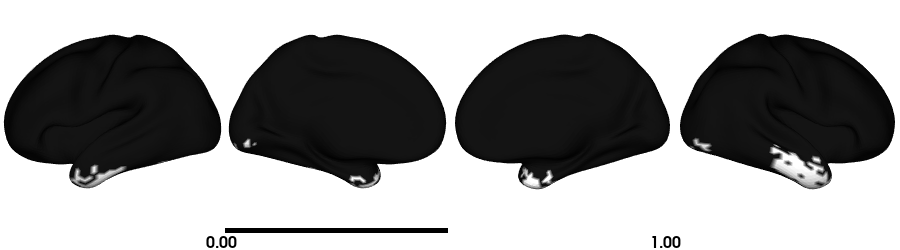

In [205]:

# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=tfod_afd_1mm<0.2, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# FOD Tournier - Dispersion

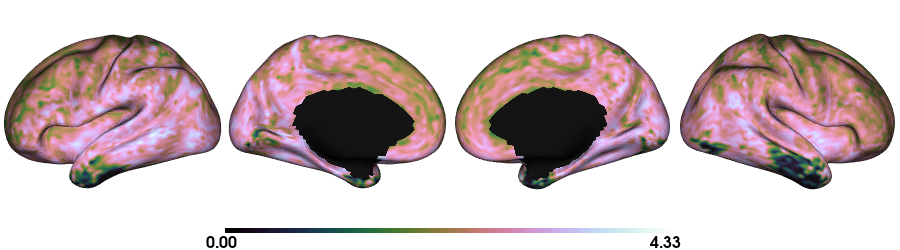

In [44]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=tfod_disp_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# FOD Tournier  - Peak

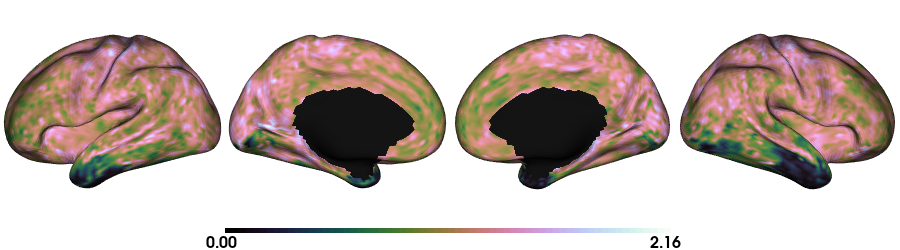

In [45]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=tfod_peak_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# FOD Dhollander - Apparent Fiber Distribution

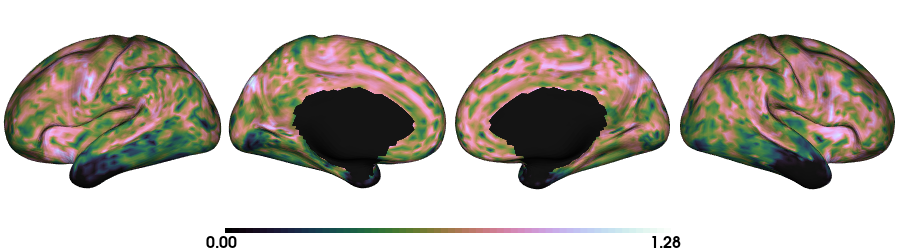

In [54]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=dfod_afd_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# FOD Dhollander - Dispersion

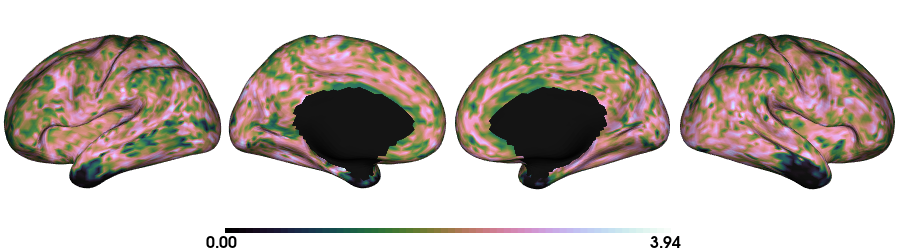

In [58]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=dfod_disp_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

# FOD Dhollander - Peak

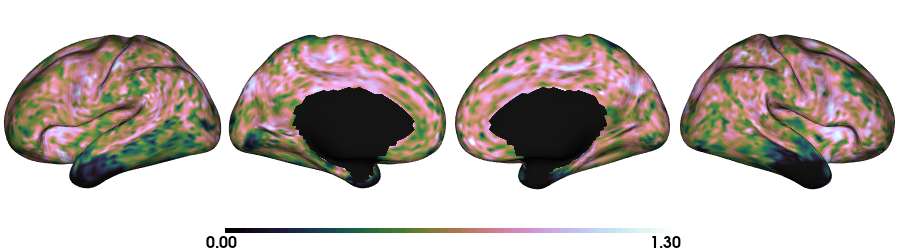

In [83]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=dfod_peak_1mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False, color_range=(0,1.3))

/tmp/ipykernel_3263371/3348255606.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


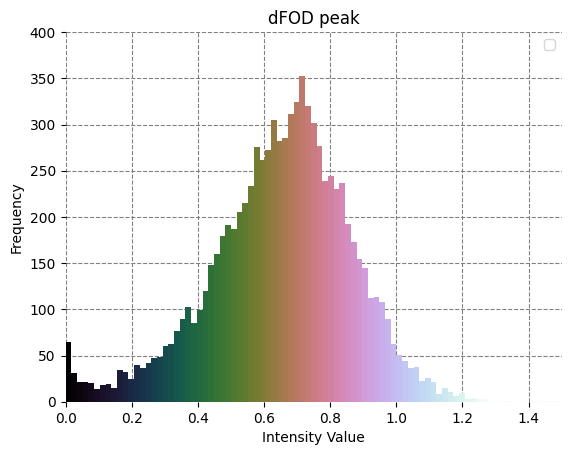

In [84]:
plot_histogram(dfod_peak_1mm, bins=100, title='dFOD peak', cmap='cubehelix', Range=(0, 1.3),
                   xlim=[0,1.5], ylim=400)

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_histogram(data, bins=100, title='Histogram', cmap='cubehelix', Range=(0, 1.5),
                   xlim=[0,1.5], ylim=400):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()

from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

# Define functions to load GD, SC, FC and MPC fsLR-32k
def load_mpc(File):
     """Loads and process a MPC"""

     # Load file
     mpc = nb.load(File).darrays[0].data

     # Mirror the lower triangle
     mpc = np.triu(mpc,1)+mpc.T

     # Replace infinite values with epsilon
     mpc[~np.isfinite(mpc)] = np.finfo(float).eps

     # Replace 0 with epsilon
     mpc[mpc==0] = np.finfo(float).eps

     # retun the MPC
     return(mpc)
     
def fslr5k_dm(mtx, mask, Ngrad=3, S=0.9, kernel='normalized_angle'):
     """Create the gradients from the MPC matrix
         S=sparcity, by default is 0.9
     """
     # Cleanup before diffusion embeding
     mtx[~np.isfinite(mtx)] = 0
     mtx[np.isnan(mtx)] = 0
     mtx[mtx==0] = np.finfo(float).eps

     # Get the index of the non medial wall regions
     indx = np.where(mask==1)[0]

     # Slice the matrix
     mtx_masked = mtx[indx, :]
     mtx_masked = mtx_masked[:, indx]

     # Calculate the gradients
     gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
     gm.fit(mtx_masked, sparsity=S)

     # Map gradients to surface
     grad = [None] * Ngrad

     # Boolean mask
     mask_surf = mask != 0

     for i, g in enumerate(gm.gradients_.T[0:Ngrad,:]):

         # create a new array filled with NaN values
         g_nan = np.full(mask_surf.shape, np.nan)
         g_nan[indx] = g
         grad[i] = g_nan

     return(gm, grad)

In [21]:
# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_PNI/derivatives'  # <<<<<<<<<<<< CHANGE THIS PATH
os.chdir(f'{out}/micapipe_v0.2.0')

Ngrad=3
Nplot = 3
# Labels for plotting based on Nplot
labels=['G'+str(x) for x in list(range(1,Nplot+1))]

In [22]:
 # MPC T1map acquisition and file
sub='PNC019'
ses='01'

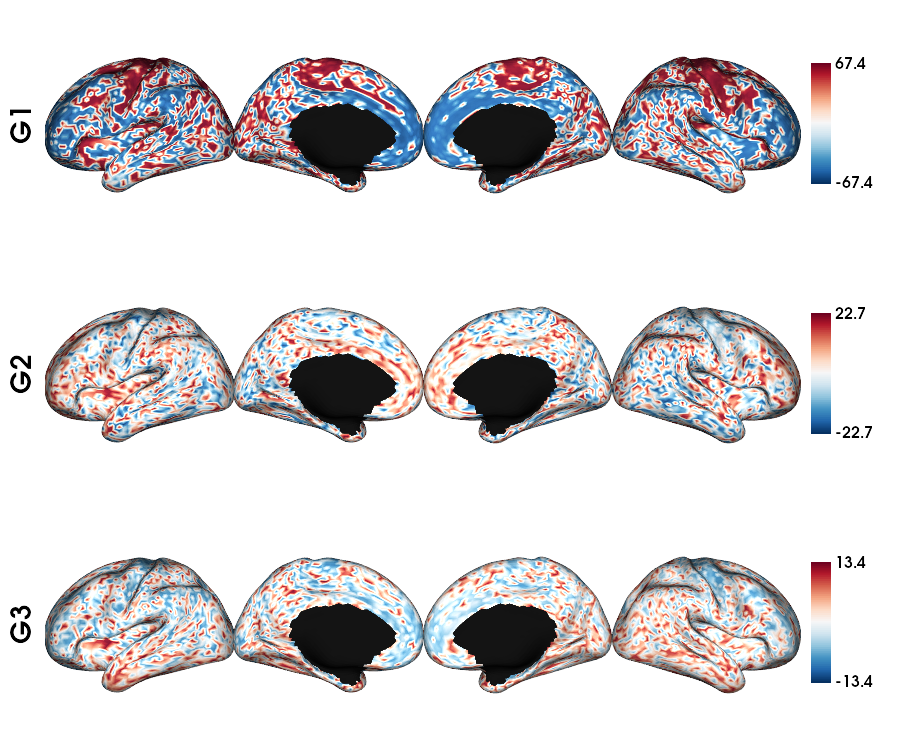

In [26]:
mpc_acq='tournier_afd'
mpc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/mpc-swm/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))

# Loads the MPC fsLR-5k matrix
mpc_5k = load_mpc(mpc_file[0])

# Calculate the gradients (diffusion map)
mpc_dm, grad = fslr5k_dm(mpc_5k, mask_10k, S=0.95, kernel=None)

# Plot the gradients
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=grad[0:3], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
   zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
   color_bar='right', label_text={'left': labels})

In [197]:
mpc_acq='tournier_dispersion'
ses='01'
mpc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/mpc-swm/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))

# Loads the MPC fsLR-5k matrix
mpc_5k = load_mpc(mpc_file[0])

# Mean value
mpc_5k_mean = np.mean(mpc_5k, axis=1) 

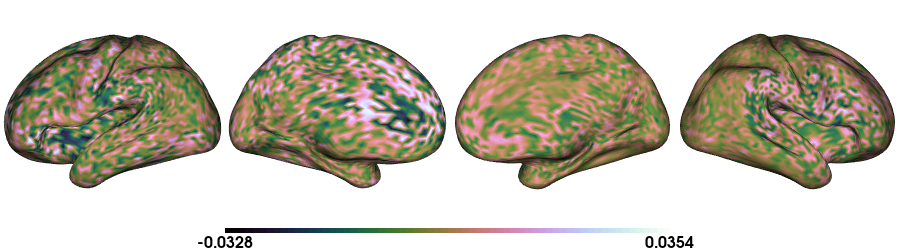

In [198]:
# Plot the surface
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=mpc_5k_mean, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                         nan_color=(0, 0, 0, 1), cmap="cubehelix", transparent_bg=False)

In [ ]:
# Calculate the gradients (diffusion map)
del(mpc_dm, grad)
mpc_dm, grad = fslr5k_dm(mpc_5k, mask_10k, S=0.92, kernel=None)

# Plot the gradients
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=grad[0:3], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
   zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
   color_bar='right', label_text={'left': labels})


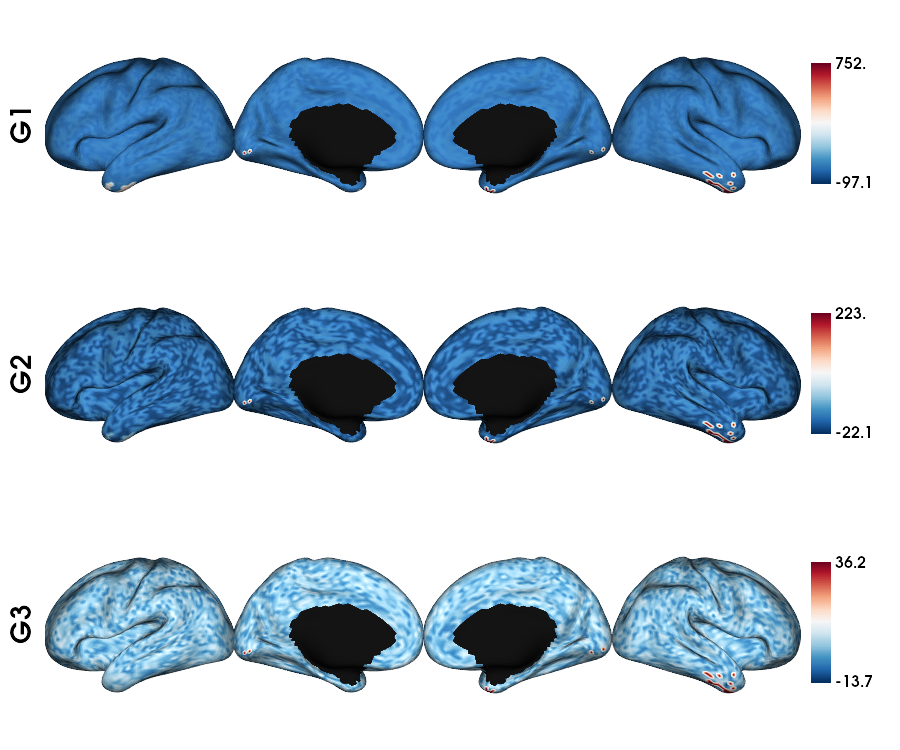

In [195]:
mpc_acq='dhollander_dispersion'
ses='01'
mpc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/mpc-swm/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))

# Loads the MPC fsLR-5k matrix
mpc_5k = load_mpc(mpc_file[0])

# Calculate the gradients (diffusion map)
mpc_dm, grad = fslr5k_dm(mpc_5k, mask_10k, S=0.8, kernel=None)

# Plot the gradients
plot_hemispheres(f5k_inf_lh, f5k_inf_rh, array_name=grad[0:3], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
   zoom=1.3, size=(900, 750), embed_nb=True,
   color_bar='right', label_text={'left': labels})


In [5]:
mpc_acq='tournier_afd'
sub='PNC019'
ses='01'
mpc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/mpc-swm/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))

# make the MPC
mpc_all = make_mpc5k(mpc_file)

# Mean matrix across the z axis (subjects)
mpc_all_avg = np.mean(mpc_all, axis=2)

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [32]:
# Calculate the gradients
Ngrad=3
mpc_all = mpc_all[0:
MPC_all, grad = mpc_dm(mpc_all[:,:,0], mask_10k, Ngrad=Ngrad, Smooth=False)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]

plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)
  #filename='/home/bic/rcruces/Desktop/MPC_PNC_3G.png')

ValueError: Unknown kernel 'False'.